In [1]:
from ANEMO import ANEMO
from ANEMO import read_edf
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
datafile = 'data/enregistrement_AM_2017-10-23_100057.asc'
data = read_edf(datafile, 'TRIALID')

expfile = 'data/enregistrement_AM_2017-10-23_100057.pkl'
with open(expfile, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')

In [3]:
A = ANEMO(exp)
Fit = ANEMO.Fit(exp)
Plot = ANEMO.Plot(exp)

In [4]:
def regress(ax, p, data, x1, x2, y1, y2, t_label=20, color='r') :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c=color, linewidth=2)
    ax.text(x2-(x2-x1)/10,y1+(y2-y1)/10, 'r = %0.3f'%(r_), color=color, fontsize=t_label/1.2, ha='right')

    #hist, x_edges, y_edges = np.histogram2d(p, data ,bins=20)
    #ax.text(x2-(x2-x1)/10,y1+2*(y2-y1)/10, 'MI = %0.3f'%(mutual_information(hist)), color=color, fontsize=t_label/1.2, ha='right')

    return ax

In [5]:
def figure(N_trial=1, N_block=1, plot='') :

    nb_trial = N_trial*N_block
    
    if plot!='scatter' :
        fig, axs = plt.subplots(nb_trial, 1, figsize=(10, nb_trial*(10*1/2)/1.6180))
    
    else :
        var_fit, var_old = {}, {}
        for var in ['latence', 'v_anti', 'steady_state'] :
            var_fit[var], var_old[var] = [], []
    
    
    for block in range(N_block) :
        
        for trial in range(N_trial) :
            
            arg = A.arg(data[trial+block*N_trial], trial=trial, block=block)
            
            velocity_NAN = A.velocity_NAN(**arg)[0]
            old = {}
            old['latence'], old['maxi'], old['v_anti'] = ANEMO.classical_method.Full(velocity_NAN, arg.TargetOn-arg.t_0)
            f = Fit.Fit_trial(velocity_NAN, equation='fct_velocity',value_latence=old['latence'],
                              value_maxi=old['maxi'], value_anti=old['v_anti'], **arg)
            
            fit = ANEMO.Equation.fct_velocity(np.arange(len(velocity_NAN)), arg.dir_target,
                                                  f.values['start_anti'], f.values['v_anti'],
                                                  f.values['latence'], f.values['tau'],
                                                  f.values['maxi'], do_whitening=False)
            
            steady_state = f.values['maxi']*arg.dir_target + fit[int(f.values['latence'])]
            
            if plot=='scatter' :
                
                for var in ['latence', 'v_anti'] :
                    var_fit[var].append(f.values[var])
                    var_old[var].append(old[var])
                var_fit['steady_state'].append(steady_state*arg.dir_target)
                var_old['steady_state'].append(old['maxi'])


            else :
                if nb_trial==1 : ax = axs
                else : ax = axs[trial]
                
                debut = arg.TargetOn-arg.t_0
                trackertime_s = arg.trackertime - arg.TargetOn
                
                ax.plot(trackertime_s, velocity_NAN, c='k', alpha=0.5)
                ax.plot(trackertime_s, fit, c='k')

                ax.bar(f.values['latence']-debut, 60, bottom=-30, color='k', width=4)
                ax.plot(trackertime_s, np.ones(len(velocity_NAN))*steady_state, c='k')

                ax.bar(old['latence']-debut, 60, bottom=-30, color='r', width=4)
                ax.plot(trackertime_s, np.ones(len(velocity_NAN))*old['maxi']*(arg.dir_target), c='r')
                
                ax.plot(np.arange(-50,50), range(100)*(old['v_anti']/1000), c='r', lw=2)
                ax = Plot.deco(ax, t_label=10, **arg)
                ax.set_ylabel('Velocity (°/s)', fontsize=10)
                ax.set_title('block %s, trial %s'%(block, trial))
                
    
                plt.tight_layout() 
        
    if plot=='scatter' :
        fig, axs = plt.subplots(1, 3, figsize=(5*3, 5/1.6180))
        for x, var in enumerate(['latence', 'v_anti', 'steady_state']) :
            axs[x].set_title(var)
            
            v_fit = np.ma.masked_array(var_fit[var], mask=np.isnan(var_old[var])).compressed()
            v_old = np.ma.masked_array(var_old[var], mask=np.isnan(var_old[var])).compressed()
            
            
            axs[x].scatter(v_old, v_fit, c='k', alpha=0.5)
            axs[x] = regress(axs[x], v_old, v_fit, x1=min(v_old), x2=max(v_old), y1=min(v_fit), y2=max(v_fit))
            axs[x].set_xlabel('old')
            axs[x].set_ylabel('fit')
        plt.tight_layout() 

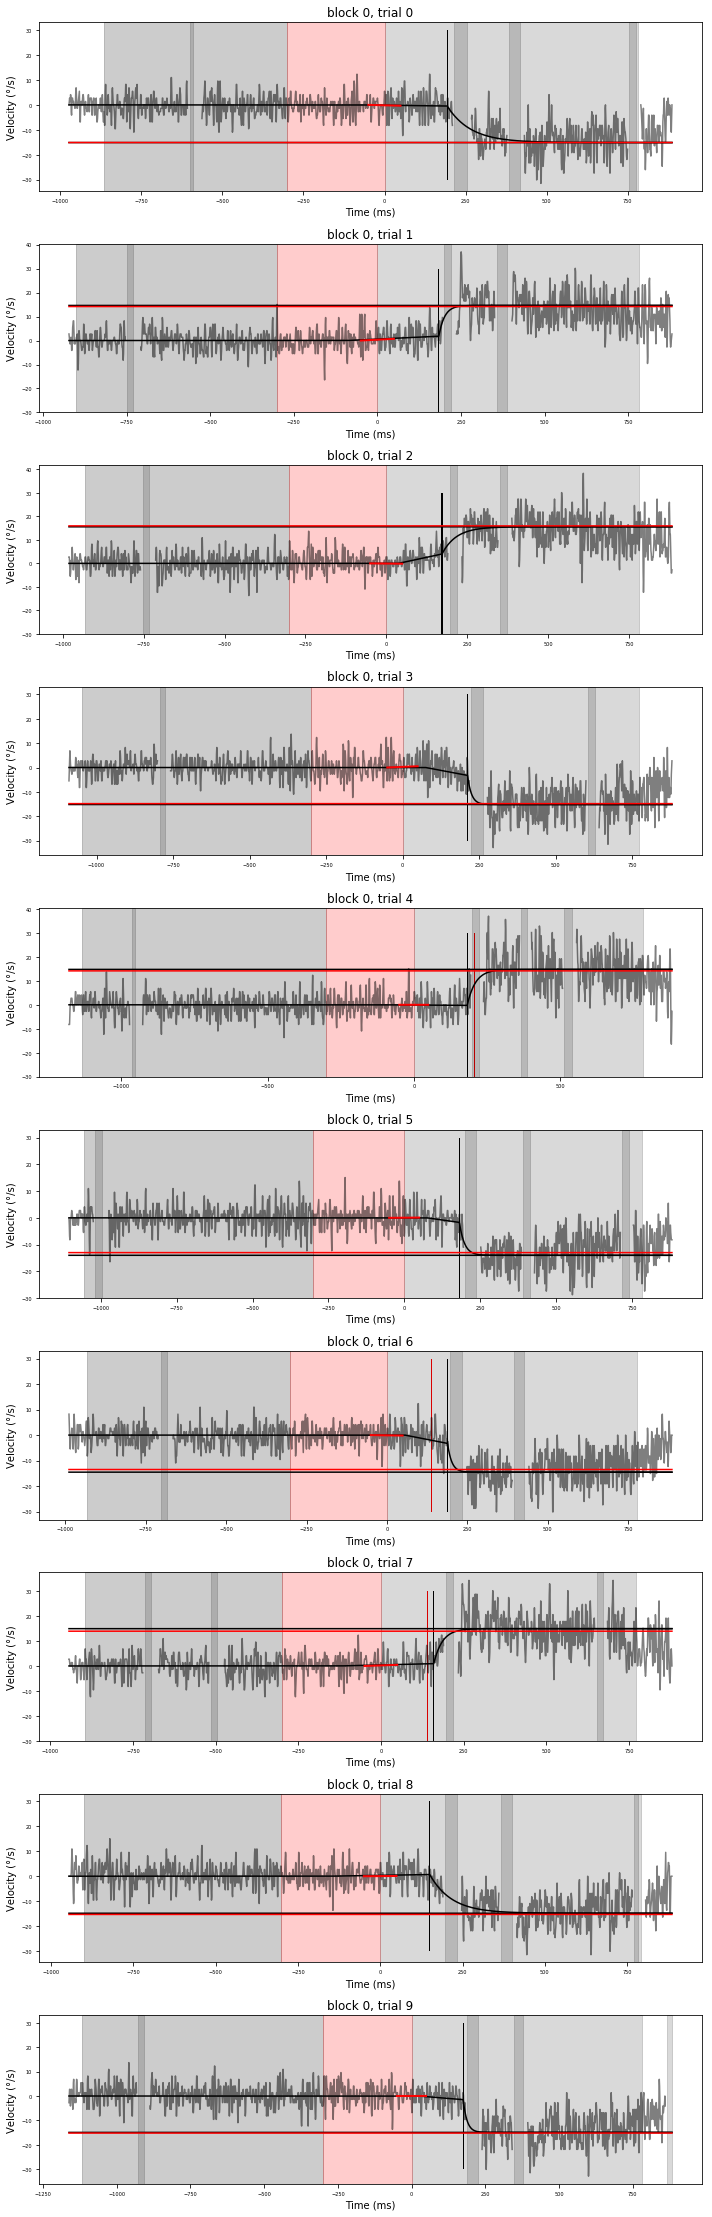

In [6]:
figure(N_trial=10)

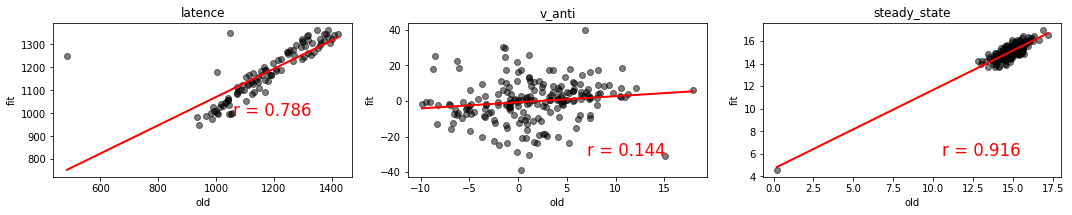

In [7]:
figure(N_trial=200, plot='scatter')